## Introduction

In this project, I'll work with data from the S&P500 Index. The S&P500 is a stock market index.

### Brief overview of indexes

Stocks are traded daily and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow us to see how the market as a whole performs. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. **The S&P500 Index aggregates the stock prices of 500 large companies.**

**When an index fund goes up or down**, it can be said that **the primary market or sector it represents is doing the same**. For example, if the Dow Jones Industrial Average price goes down one day, you can say that American stocks overall went down (ie, most American stocks went down in price).

- Exchange Traded Funds (ETFs) tranding allow us to buy and sell indexes like stocks. This means that you could "buy" the S&P500 Index ETF when the price is low and sell when it's high to make a profit. 

### About the project

I'll be using historical data on the price of the S&P500 Index to make predictions about future prices. 
- Predicting whether an index goes up or down helps forecast how the stock market as a whole performs. 
- Since stocks tend to correlate with how well the economy as a whole is performs, it can also help with economic forecasts.

Creating a predictive model could allow traders to make money on the stock market.

**Note**: This project is just for learning. Not to be used as trading in stock market.

####  Project predictive model could allow traders to make money on the stock market.

**Data:** The data is a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
- Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more [here](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).
    - **Training set**: Data from 1950-2012
    - **Test set**: Data from 2013-2015.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold
# avoid warning while plotting datetime graphs in matplotlib
pd.plotting.register_matplotlib_converters()
df=pd.read_csv("sphist.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


Note:When pandas is imported, it overwrites matplotlib's built-in datetime plotting with pandas datetime plotting. That is what generated warning. Simply add " pandas.plotting.register_matplotlib_convertersregister_matplotlib_converters()" to avoid warning while plotting datetime values in matplotlib.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null object
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: float64(6), object(1)
memory usage: 907.3+ KB


In [3]:
# Converting Date column to datetime class 
df["Date"]=pd.to_datetime(df["Date"])
df=df.sort_values("Date",ascending=True)


df.head()


,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16590 entries, 16589 to 0
Data columns (total 7 columns):
Date         16590 non-null datetime64[ns]
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


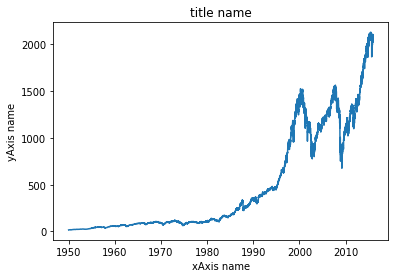

In [5]:
plt.plot(df["Date"],df["Adj Close"])
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

**Remark:** We can see a significant upward trend here reflecting a price increase from 16.052002 to over 2000 in past 5 decades. That’s a significant increase. Let’s see if we can’t develop a linear regression model that might help predict upward trends like this!



# Feature Engineering

Stock market data is sequential and each observation comes a day after the previous observation. Thus, the observations are not all independent and you can't treat them as such.

This means you have to be extra careful not to inject "future" knowledge into past rows when we train and predict. Injecting future knowledge makes our model look good when we train and test it, but it fails in the real world. This is how many algorithmic traders lose money.

**The time series nature of the data means that we can generate indicators to make our model more accurate.** For instance, you can **create a new column that contains the average price of the last 10 trades for each row.** 
    - This incorporates information from multiple prior rows into one and makes predictions much more accurate.
**Note: Don't include current row value when taking averages to create new column**

Here are some indicators that are interesting to generate for each row:

- The average price from the past 5 days.
- The average price for the past 30 days.
- The average price for the past 365 days.
- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- The standard deviation of the price over the past 5 days.
- The standard deviation of the price over the past 365 days.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

"Days" means "trading days" -- so if we're computing the average of the past 5 days, it should be the 5 most recent dates before the current one. Assume that **"price"** means the **Close column**.

Some of these indicators require a year of historical data to compute. Our first day of data falls on 1950-01-03, so the first day you can start computing indicators on is 1951-01-03.

To compute indicators, we'll need to loop through each day from 1951-01-03 to 2015-12-07 (the last day you have prices for). For instance, if we were computing the average price from the past 5 days, we'd start at 1951-01-03, get the prices for each day from 1950-12-26 to 1951-01-02, and find the average. The reason why we start on the 26th, and take more than 5 calendar days into account is because the stock market is shutdown on certain holidays. Since we're looking at the past 5 trading days, we need to look at more than 5 calendar days to find them. Here's a diagram showing how we average 5 days to get the average closing price for 1951-01-03:

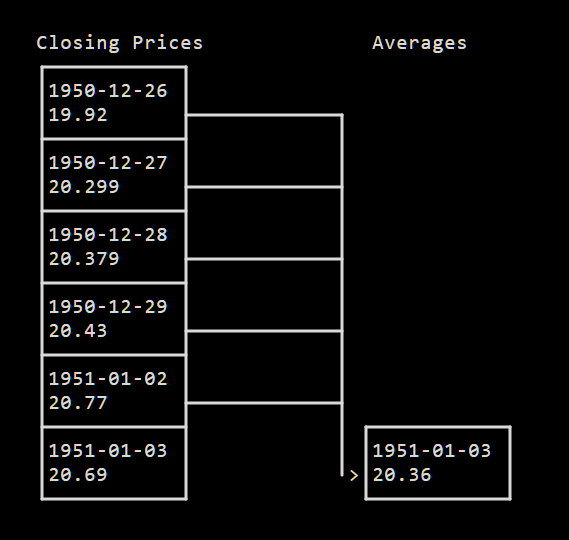

We'd keep repeating this process to compute all of the averages. Note how when we compute the average of the past 5 days for 1951-01-04, we don't include 1951-01-04 in that average. It's critical not to do this, or our model won't work in the "real world".

Let's pick 3 indicators to compute, and generate a different column for each one.

There are a few different ways to do this:

1. We can use a for loop along with the **iterrows method to loop over the rows** in the DataFrame and compute the indicators. Since we'll be looping over all of the rows, for any date that comes before there is enough historical data to compute an indicator, just fill in 0.
2. Pandas has some time series tools like including the *rolling function*. **In rolling function, Set the window equal to the number of trading days in the past we want to use to compute the indicators.** This will add in NaN values for any row where there aren't enough historical trading days to do the computation. 
 - **Note**: There is a giant caveat here, which is that the **rolling mean will use the current day's price. We'll need to reindex the resulting series to shift all the values "forward" one day.** For example, the rolling mean calculated for 1950-01-03 will need to be assigned to 1950-01-04, and so on. We can use the **shift method on Dataframes** to do this.

In [6]:
def n_day_avg(df,n):
    for index,row in df.iterrows():
        start_index=index+n
        end_index=index+1
        if start_index not in df.index:
            if n in [5,365]:
                df.loc[index,"{}_day_avg_price".format(n)]=0
                df.loc[index,"{}_day_std".format(n)]=0
            else:
                df.loc[index,"{}_day_avg_price".format(n)]=0
        else:
            # df is in asce order of dates. So,index starts at 16589
            if n in [5,365]:
                df.loc[index,"{}_day_avg_price".format(n)]=round(df.loc[start_index:index+1,"Close"].mean(),2)
                df.loc[index,"{}_day_std".format(n)]=round(df.loc[start_index:index+1,"Close"].std(),2)
            else:
                df.loc[index,"{}_day_avg_price".format(n)]=round(df.loc[start_index:index+1,"Close"].mean(),2)
    return df  
# Alternate to above defined function
# #Calculate the mean for the past 5, 30, 365 days (need shift a row as rolling includes current value while computing)
# df['day_5'] = df['Close'].rolling(5).mean().shift(1)
# df['day_30'] = df['Close'].rolling(30).mean().shift(1)
# df['day_365'] = df['Close'].rolling(365).mean().shift(1)

# #Calculate the STD for the past 5, 365 days
# df['std_5'] = df['Close'].rolling(5).std().shift(1)
# df['std_365'] = df['Close'].rolling(365).std().shift(1)


#Calculate the mean for the past 5, 30, 365 days and std for past 5,365 days
for n in [5,30,365]:
    n_day_avg(df,n)
    
df.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg_price,5_day_std,30_day_avg_price,365_day_avg_price,365_day_std
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,0.00,0.00,0.0,0.0,0.0
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,0.00,0.00,0.0,0.0,0.0
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,0.00,0.00,0.0,0.0,0.0
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,0.00,0.00,0.0,0.0,0.0
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,0.00,0.00,0.0,0.0,0.0
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.90,0.16,0.0,0.0,0.0
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.97,0.09,0.0,0.0,0.0
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.02,0.07,0.0,0.0,0.0
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.99,0.13,0.0,0.0,0.0
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.93,0.20,0.0,0.0,0.0


In [7]:
df.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg_price,5_day_std,30_day_avg_price,365_day_avg_price,365_day_std
9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,2071.52,18.25,2061.89,2033.61,64.91
8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,2078.20,15.81,2064.20,2034.02,64.77
7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,2085.94,3.49,2067.05,2034.43,64.63
6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,2087.00,3.40,2070.20,2034.84,64.51
5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,2088.78,1.31,2072.41,2035.20,64.45
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.02,3.92,2073.98,2035.53,64.37
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.23,7.96,2076.28,2035.91,64.35
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.31,9.33,2077.91,2036.23,64.28
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.46,19.60,2078.93,2036.51,64.12
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.77,19.81,2080.24,2036.87,64.06


In [8]:
#Calculate the mean volume for the past 5, 365 days
df['day_5_volume'] = df['Volume'].rolling(5).mean().shift(1)
df['day_365_volume'] = df['Volume'].rolling(365).mean().shift(1)

#Calculate the STD of the average volume over the past five days
df['5_volume_std'] = df['day_5_volume'].rolling(5).std().shift(1)

df.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,5_day_avg_price,5_day_std,30_day_avg_price,365_day_avg_price,365_day_std,day_5_volume,day_365_volume,5_volume_std
9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,2071.52,18.25,2061.89,2033.61,64.91,3.930538e+09,3.523622e+09,6.821252e+07
8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,2078.20,15.81,2064.20,2034.02,64.77,3.899886e+09,3.526334e+09,6.979154e+07
7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,2085.94,3.49,2067.05,2034.43,64.63,3.791402e+09,3.528961e+09,7.278537e+07
6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,2087.00,3.40,2070.20,2034.84,64.51,3.576712e+09,3.528637e+09,1.077890e+08
5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,2088.78,1.31,2072.41,2035.20,64.45,3.144458e+09,3.524258e+09,1.652146e+08
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.02,3.92,2073.98,2035.53,64.37,3.207544e+09,3.527800e+09,3.241733e+08
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.23,7.96,2076.28,2035.91,64.35,3.232372e+09,3.526090e+09,3.390314e+08
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.31,9.33,2077.91,2036.23,64.28,3.245514e+09,3.529468e+09,2.803620e+08
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.46,19.60,2078.93,2036.51,64.12,3.536224e+09,3.532802e+09,1.696382e+08
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.77,19.81,2080.24,2036.87,64.06,4.085838e+09,3.535838e+09,1.520693e+08


## Splitting the data

Since we're computing indicators that use historical data, there are some rows where there isn't enough historical data to generate them. Some of the indicators use 365 days of historical data and the dataset starts on 1950-01-03. Thus, any rows that fall before 1951-01-03 don't have enough historical data to compute all the indicators. We'll need to remove these rows before you split the data.



In [9]:
#Removing any rows from the DataFrame that occur before 1951-01-03
df=df[df["Date"] > datetime(year=1951, month=1, day=2)]

In [10]:
df = df.dropna(axis=0)

In [11]:
# train contains rows with a date less than 2013-01-01 and test contains rows with a date greater than or equal to 2013-01-01.

train=df[df["Date"]<=datetime(year=2012, month=12, day=31)]
test=df[df["Date"]>=datetime(year=2013, month=1, day=1)]

## Training and testing the model

Let's use **Mean Absolute Error**, also called MAE, as an error metric, because it will show us how "close" we were to the price in intuitive terms. Mean Squared Error, or MSE, is an alternative that is more commonly used, but makes it harder to intuitively tell how far off we are from the true price because it squares the error.

Leave out all of the original columns (Close, High, Low, Open, Volume, Adj Close, Date) when training your model. These all contain knowledge of the future that you don't want to feed the model. Use the Close column as the target.

We can now predict the S&P500 (with some error). We can improve the error of this model significantly, though. Think about some indicators that might be helpful to compute.

Here are some ideas that might be helpful:

- The average volume over the past five days.
- The average volume over the past year.
- The ratio between the average volume for the past five days, and the average volume for the past year.
- The standard deviation of the average volume over the past five days.
- The standard deviation of the average volume over the past year.
- The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
- The year component of the date.
- The ratio between the lowest price in the past year and the current price.
- The ratio between the highest price in the past year and the current price.
- The month component of the date.
- The day of week.
- The day component of the date.
- The number of holidays in the prior month.

In [12]:
features=df.columns.tolist()[7:]


In [13]:
def train_test(train,test):
    lr=LinearRegression()
    features=df.columns.tolist()[7:]
    model=lr.fit(train[features],train["Close"])
    predictions=model.predict(test[features])
    mae=mean_absolute_error(test["Close"],predictions)
    return mae

mae=train_test(train,test)
mae

16.116193238401838

In [14]:
train_1=df[df["Date"]<=datetime(year=2013, month=1, day=2)]
test_1=df[df["Date"]>=datetime(year=2013, month=1, day=3)]

mae_1=train_test(train_1,test_1)
mae_1

16.07762023249575

In [15]:
train_2=df[df["Date"]<=datetime(year=2013, month=1, day=4)]
test_2=df[df["Date"]>=datetime(year=2013, month=1, day=5)]

mae_2=train_test(train_2,test_2)
mae_2

16.02749950591406

In [19]:
$ pip install pandas_ta
import pandas_ta as ta
df=df.ta.ema(close='Close', length=10, append=True)
df.head(20)

SyntaxError: invalid syntax (<ipython-input-19-d9834e457d3f>, line 1)

# Conclusion
Accuracy is improving greatly by making predictions only one day ahead. For example, train a model using data from 1951-01-03 to 2013-01-02, make predictions for 2013-01-03, and then train another model using data from 1951-01-03 to 2013-01-03, make predictions for 2013-01-04, and so on. This more closely simulates what you'd do if you were trading using the algorithm.

**Our models performance improved from 16.11 to 16.02 when predictions were made 2 days ahead.** We can also improve the algorithm used significantly. Trying other techniques, like a random forest, and to see if they perform better.

We can also incorporate outside data, such as the weather in New York City (where most trading happens) the day before and the amount of Twitter activity around certain stocks.

We can also make the system real-time by writing an automated script to download the latest data when the market closes and make predictions for the next day.

Finally, We can make the system "higher-resolution". We're currently making daily predictions, but we could make hourly, minute-by-minute, or second-by-second predictions. This requires obtaining more data, though. We could also make predictions for individual stocks instead of the S&P500.